In [1]:
# Import the required libraries.
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
# %matplotlib inline
 
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 256, 256
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 8
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = r'D:\final_occlusion'
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["occlusion", "good"]

In [4]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255.0
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [5]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [6]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: occlusion
Extracting Data of Class: good


In [7]:
# print(type(features), type(labels), type(video_files_paths))
# print(features)

np.save('final_features_dec.npy', features)
np.save('final_labels_dec.npy', labels)
f = np.load('final_features_dec.npy')
l = np.load('final_labels_dec.npy')

# print(f==features, l==labels)


In [8]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(l)
# print(one_hot_encoded_labels)

In [9]:
# Split the Data into Train ( 80% ) and Temp Set ( 20% ).
features_train, features_tmp, labels_train, labels_tmp = train_test_split(f, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

# print(labels_train)

# Split the Temp Data into Validation ( 10% ) and Test Set ( 10% ).
features_val, features_test, labels_val, labels_test = train_test_split(features_tmp, labels_tmp, test_size = 0.5, shuffle = True, random_state = seed_constant)


print(len(f), len(l))
print(len(features_train), len(labels_train))
print(len(features_val), len(labels_val))
print(len(features_test), len(labels_test))

np.save('final_features_train.npy', features_train)
np.save('final_labels_train.npy', labels_train)

np.save('final_features_val.npy', features_val)
np.save('final_labels_val.npy', labels_val)

np.save('final_features_test.npy', features_test)
np.save('final_labels_test.npy', labels_test)



263 263
210 210
26 26
27 27


In [35]:
features_train = np.load('final_features_train.npy')
labels_train = np.load('final_labels_train.npy')

features_val = np.load('final_features_val.npy')
labels_val = np.load('final_labels_val.npy')

features_test = np.load('final_features_test.npy')
labels_test = np.load('final_labels_test.npy')

# print(type(features_train))

<class 'numpy.ndarray'>


In [40]:
print(labels_test.shape)

(27, 2)


In [12]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (5, 5), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (5, 5), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(2, activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [13]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 8, 256, 256, 16)  1216      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 8, 64, 64, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 8, 64, 64, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 8, 64, 64, 32)    12832     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 8, 16, 16, 32)    0

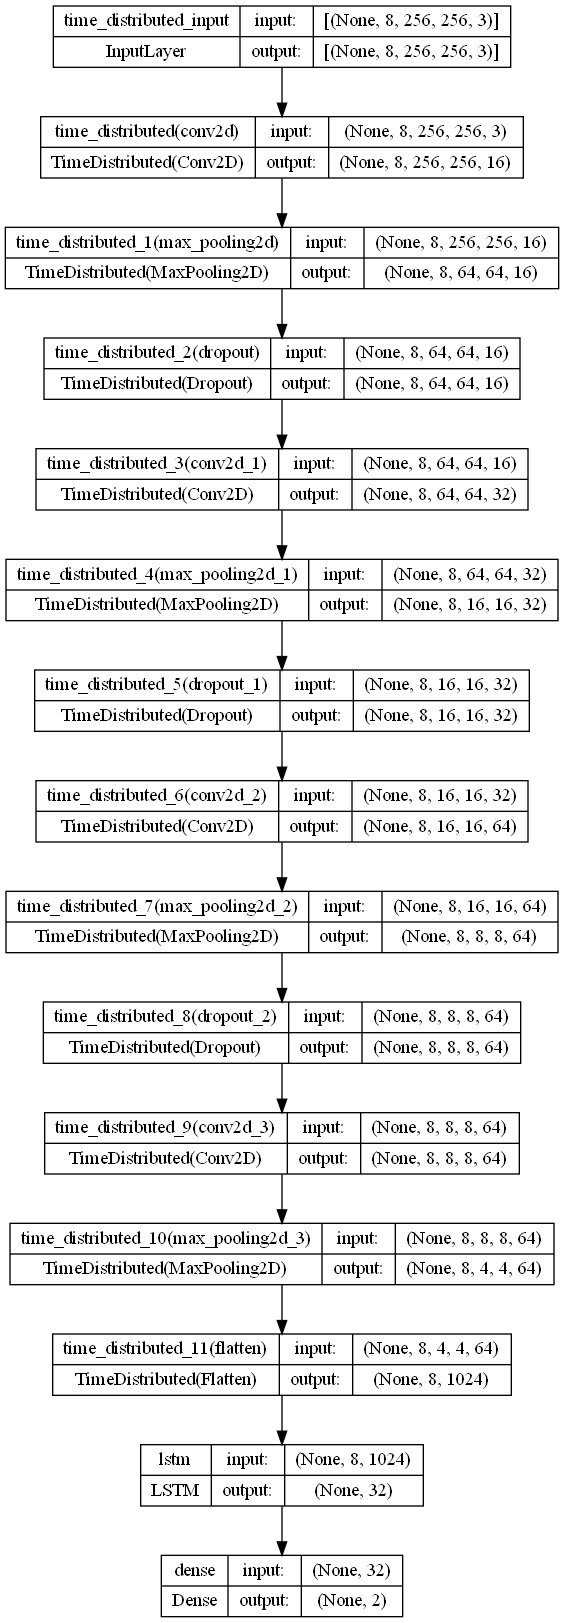

In [14]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [15]:
from tensorflow.keras.metrics import Precision, Recall

# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
opt = keras.optimizers.Adam(learning_rate=0.0001)
LRCN_model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.15, callbacks = [early_stopping_callback])

Epoch 1/50
45/45 [==============================] - 31s 629ms/step - loss: 0.6670 - accuracy: 0.5730 - precision: 0.5730 - recall: 0.5730 - val_loss: 0.6793 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938
Epoch 2/50
45/45 [==============================] - 27s 608ms/step - loss: 0.6336 - accuracy: 0.6348 - precision: 0.6348 - recall: 0.6348 - val_loss: 0.6671 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938
Epoch 3/50
45/45 [==============================] - 27s 603ms/step - loss: 0.6290 - accuracy: 0.6573 - precision: 0.6573 - recall: 0.6573 - val_loss: 0.6790 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938
Epoch 4/50
45/45 [==============================] - 27s 604ms/step - loss: 0.6039 - accuracy: 0.7360 - precision: 0.7360 - recall: 0.7360 - val_loss: 0.6606 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938
Epoch 5/50
45/45 [==============================] - 31s 691ms/step - loss: 0.5766 - accuracy: 0.7528

45/45 [==============================] - 34s 744ms/step - loss: 0.1312 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - val_loss: 0.3164 - val_accuracy: 0.8438 - val_precision: 0.8438 - val_recall: 0.8438
Epoch 38/50
45/45 [==============================] - 47s 1s/step - loss: 0.1102 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - val_loss: 0.2631 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062


In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
    
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
    plt.xlabel("epochs")
    plt.ylabel(metric_name_1)
    
    plt.title(str(plot_name))
    
    plt.legend()

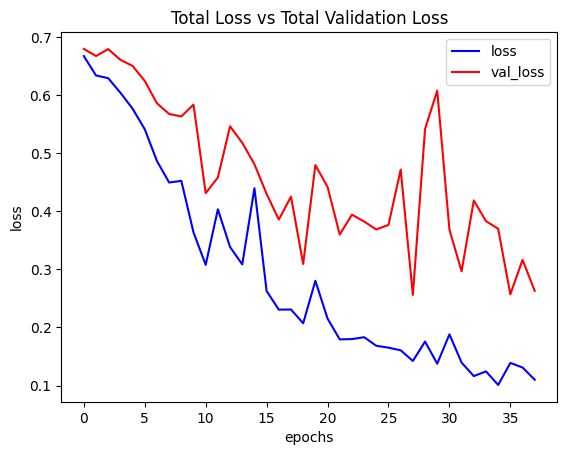

In [17]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

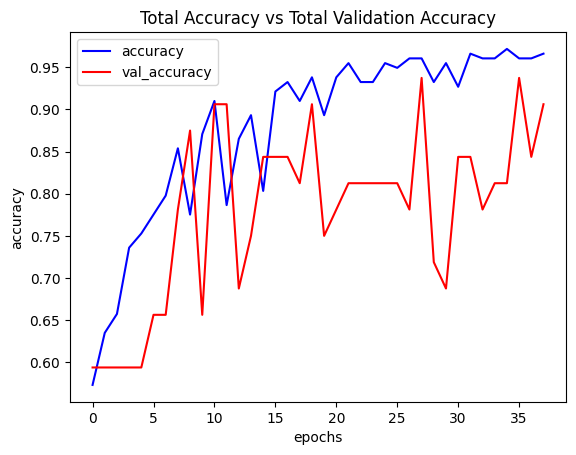

In [18]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [19]:
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_8model___Date_Time_{current_date_time_string}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

In [21]:
from keras.models import load_model

# Load the saved model.
LRCN_loaded_model = load_model(r"D:\final_occlusion\results\adam0001\LRCN_8model___Date_Time_2023_06_14__15_58_17.h5")

In [22]:
# Evaluating the model.
model_evaluation_history = LRCN_loaded_model.evaluate(features_val, labels_val)

1/1 [==============================] - 2s 2s/step - loss: 0.2153 - accuracy: 0.8846 - precision: 0.8846 - recall: 0.8846


In [23]:
# Get the loss, accuracy, precision, recall from model_evaluation_history.
res = model_evaluation_history

print(res)

[0.21529117226600647, 0.8846153616905212, 0.8846153616905212, 0.8846153616905212]


In [41]:
f_t = np.append(features_train, features_test, axis = 0)
l_t = np.append(labels_train, labels_test, axis = 0)

features = np.append(f_t, features_val, axis = 0)
labels = np.append(l_t, labels_val, axis = 0)

9/9 [==============================] - 14s 1s/step
[1.9999312  0.9999312  0.851678   0.84712875 0.66294765 0.6307959
 0.56853575 0.45990956 0.45050564 0.3540192  0.2490103  0.23241419
 0.17151375 0.07721456 0.0759519  0.06948811 0.06749313 0.04704159
 0.04689969 0.04157634 0.04078055 0.03271584 0.03249658 0.00994111]


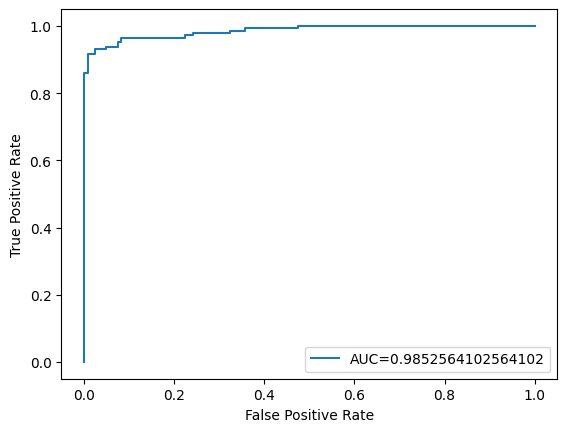

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

# labels_test_pred = LRCN_loaded_model.predict(features_test)

predict_prob = LRCN_loaded_model.predict(features)

predict_cls = []

for p in predict_prob:
    predict_cls.append(p[0])
    
# print(predict_cls)

predict_classes = np.argmax(predict_prob,axis=1)
# predict_classes = [a[0] for a in predict_prob]

true_cls = []
for t in labels:
    true_cls.append(t[0])
    
true_classes = np.argmax(labels_test,axis=1)
# true_classes = [a[0] for a in labels_test]


auc = metrics.roc_auc_score(true_cls, predict_cls)

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(true_cls, predict_cls)

print(threshold1)


plt.plot(false_positive_rate1, true_positive_rate1, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [12]:
def inverse_one_hot_encoding(l):
    if (l == np.array([0, 1])).all():
        return 0
    if (l == np.array([1, 0])).all():
        return 1
    else:
        return -1

In [13]:
# Plot confusion matrix.
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

pred_val = []
true_val = []

for i in range(0, len(labels_test_pred)):
    p = inverse_one_hot_encoding(np.rint(labels_test_pred[i]))
    pred_val.append(p)
    
    t = inverse_one_hot_encoding(np.rint(labels_test[i]))
    true_val.append(t)

cm = confusion_matrix(true_val, pred_val)

# print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)

disp.plot(cmap=plt.cm.Blues)
plt.show()


NameError: name 'labels_test_pred' is not defined

0.8303030303030303


[0.27272727 0.06666667] [0.93333333 0.72727273]


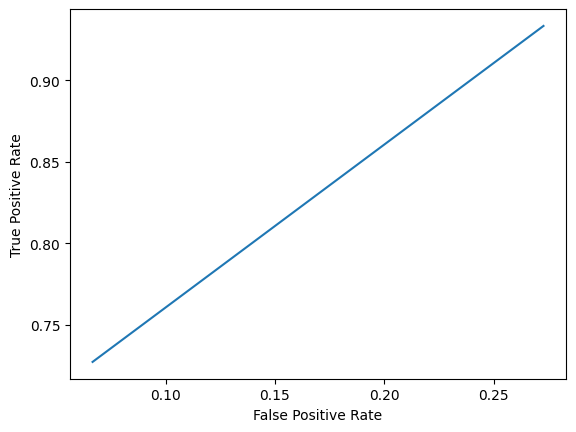

In [53]:
cap  = cv2.VideoCapture(r"D:\occlusion_data\train\occlusion\train_0027.avi")

cap.get(cv2.CAP_PROP_FRAME_COUNT)

65.0

In [56]:
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) 
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
print(h,w)

720.0 1280.0


In [57]:
fps = cap.get(cv2.CAP_PROP_FPS)

In [58]:
print(fps)

25.0


In [59]:
cap.release()

In [47]:
import time
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
    ct = 0 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
        ct+=1

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
            
            st = time.time()
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_loaded_model.predict(np.expand_dims(frames_queue, axis = 0), verbose=0)[0]
            et = time.time()
            
            print('time: ', et-st)
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()
    print(ct)

In [48]:
import time

input_video_file_path = r"D:\final_occlusion\test\test_0007.avi"
# input_video_file_path = r"D:\final_occlusion\test\crow_occ.mp4"

tmp = input_video_file_path.split("\\")
filename = tmp[-1]
filename = filename[:-4]
print(filename)

test_videos_directory = r"D:\final_occlusion\predicted_result"
video_title = f'{filename}_predicted'

 
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

st = time.time()
# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
et = time.time()

print('time: ', et-st)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

test_0007
time:  0.3455698490142822
time:  0.34032702445983887
time:  0.3553123474121094
time:  0.3571193218231201
time:  0.3540229797363281
time:  0.3855741024017334
time:  0.3704497814178467
time:  0.37680840492248535
time:  0.39099669456481934
time:  0.3757133483886719
time:  0.343311071395874
time:  0.35480833053588867
time:  0.35683608055114746
time:  0.353132963180542
time:  0.3558979034423828
time:  0.34661173820495605
time:  0.35799169540405273
time:  0.3569211959838867
time:  0.3727235794067383
time:  0.36299753189086914
time:  0.35649681091308594
time:  0.35513877868652344
time:  0.3713088035583496
time:  0.3939955234527588
time:  0.3886096477508545
time:  0.36499905586242676
time:  0.3981008529663086
time:  0.43665051460266113
time:  0.38245201110839844
time:  0.3681313991546631
time:  0.343001127243042
time:  0.389171838760376
time:  0.3650040626525879
time:  0.3466484546661377
time:  0.3472633361816406
time:  0.35881638526916504
time:  0.3690028190612793
time:  0.356014251

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [44]:
cap = cv2.VideoCapture(input_video_file_path)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print( length)

73
